## Step 1. Prepare the CSV Files (Annotations and Classes)

We need 2 csv files as the input to train an object detector in notebook 3.

- The first csv contains 6 columns: file name of the image, bounding box information (xmin, ymin, xmax, ymax), and the class of the object inside the bounding box.
- The second csv file contains a list of all the classes. In this case, there are 6 classes (ringed seal, ringed pup, bearded seal, bearded pup, unknown seal, unknown pup).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#this csv file contains all information on the annotated images
#including file name, bouding box information, class
train = pd.read_csv("/content/gdrive/MyDrive/project_6/csv_files/annot_train.csv")

In [ ]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3509 entries, 0 to 3508
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   flight           3509 non-null   object 
 1   camera_view      3509 non-null   object 
 2   dt               3509 non-null   object 
 3   detection_id     3509 non-null   object 
 4   detection_type   3509 non-null   object 
 5   detection_score  3509 non-null   float64
 6   rgb_image_name   3509 non-null   object 
 7   rgb_left         3509 non-null   int64  
 8   rgb_right        3509 non-null   int64  
 9   rgb_top          3509 non-null   int64  
 10  rgb_bottom       3509 non-null   int64  
 11  ir_image_name    3418 non-null   object 
 12  ir_left          3418 non-null   float64
 13  ir_right         3418 non-null   float64
 14  ir_top           3418 non-null   float64
 15  ir_bottom        3418 non-null   float64
 16  rgb_image_path   3509 non-null   object 
 17  ir_image_path 

,flight,camera_view,dt,detection_id,detection_type,detection_score,rgb_image_name,rgb_left,rgb_right,rgb_top,rgb_bottom,ir_image_name,ir_left,ir_right,ir_top,ir_bottom,rgb_image_path,ir_image_path
0,fl04,C,20190510_000311.417294,test_kamera_fl04_C_82,ringed_seal,0.723258,test_kotz_2019_fl04_C_20190510_000311.417294_r...,3114,3176,3534,3484,test_kotz_2019_fl04_C_20190510_000311.417294_i...,315.490,321.359,363.0450,358.2940,Images/fl04/CENT/test_kotz_2019_fl04_C_2019051...,Images/fl04/CENT/test_kotz_2019_fl04_C_2019051...
1,fl04,C,20190510_000529.416720,test_kamera_fl04_C_303,ringed_seal,0.999502,test_kotz_2019_fl04_C_20190510_000529.416720_r...,3136,3210,3746,3682,test_kotz_2019_fl04_C_20190510_000529.416720_i...,317.440,324.447,383.0940,377.0150,Images/fl04/CENT/test_kotz_2019_fl04_C_2019051...,Images/fl04/CENT/test_kotz_2019_fl04_C_2019051...
2,fl04,C,20190510_000529.416720,test_kamera_fl04_C_304,ringed_seal,0.998790,test_kotz_2019_fl04_C_20190510_000529.416720_r...,3276,3345,3756,3695,test_kotz_2019_fl04_C_20190510_000529.416720_i...,330.622,337.157,384.0950,378.3020,Images/fl04/CENT/test_kotz_2019_fl04_C_2019051...,Images/fl04/CENT/test_kotz_2019_fl04_C_2019051...
3,fl04,C,20190510_001905.413279,test_kamera_fl04_C_6895,ringed_seal,0.652056,test_kotz_2019_fl04_C_20190510_001905.413279_r...,6288,6316,105,60,test_kotz_2019_fl04_C_20190510_001905.413279_i...,616.461,619.125,40.3119,36.0477,Images/fl04/CENT/test_kotz_2019_fl04_C_2019051...,Images/fl04/CENT/test_kotz_2019_fl04_C_2019051...
4,fl04,C,20190510_001910.663404,test_kamera_fl04_C_6976,ringed_pup,1.000000,test_kotz_2019_fl04_C_20190510_001910.663404_r...,3513,3551,247,193,test_kotz_2019_fl04_C_20190510_001910.663404_i...,354.979,358.590,52.5781,47.4592,Images/fl04/CENT/test_kotz_2019_fl04_C_2019051...,Images/fl04/CENT/test_kotz_2019_fl04_C_2019051...


In [ ]:
#double check that we have 1,000 images for train
train["rgb_image_name"].unique().shape[0], train["rgb_image_path"].unique().shape[0]

(1000, 1000)

In [ ]:
train["detection_score"].describe()
#mostly 1
#where are the scores from?
#Maybe they are confidence scores from another object detection study
#But these scores are really high

count    3509.000000
mean        0.994570
std         0.029613
min         0.652056
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: detection_score, dtype: float64

In [ ]:
train["detection_type"].value_counts(normalize=True).round(4)
#81% ringed_seal

ringed_seal     0.8085
unknown_seal    0.1109
bearded_seal    0.0388
ringed_pup      0.0231
unknown_pup     0.0185
bearded_pup     0.0003
Name: detection_type, dtype: float64

In [ ]:
#we only need the file name, bounding box information, class (detection_type)
#we only work with rgb images in this project
cols_to_keep = ["rgb_image_name", "rgb_left", "rgb_bottom", "rgb_right", "rgb_top", "detection_type"]

data = train[cols_to_keep]
data.head()

,rgb_image_name,rgb_left,rgb_bottom,rgb_right,rgb_top,detection_type
0,test_kotz_2019_fl04_C_20190510_000311.417294_r...,3114,3484,3176,3534,ringed_seal
1,test_kotz_2019_fl04_C_20190510_000529.416720_r...,3136,3682,3210,3746,ringed_seal
2,test_kotz_2019_fl04_C_20190510_000529.416720_r...,3276,3695,3345,3756,ringed_seal
3,test_kotz_2019_fl04_C_20190510_001905.413279_r...,6288,60,6316,105,ringed_seal
4,test_kotz_2019_fl04_C_20190510_001910.663404_r...,3513,193,3551,247,ringed_pup


In [ ]:
#change column names
new_cols_name = {"rgb_image_name": "filename",
                 "rgb_left": "xmin",
                 "rgb_bottom": "ymin",
                 "rgb_right": "xmax",
                 "rgb_top": "ymax",
                 "detection_type": "class"}
data = data.rename(columns = new_cols_name)
data.head()

,filename,xmin,ymin,xmax,ymax,class
0,test_kotz_2019_fl04_C_20190510_000311.417294_r...,3114,3484,3176,3534,ringed_seal
1,test_kotz_2019_fl04_C_20190510_000529.416720_r...,3136,3682,3210,3746,ringed_seal
2,test_kotz_2019_fl04_C_20190510_000529.416720_r...,3276,3695,3345,3756,ringed_seal
3,test_kotz_2019_fl04_C_20190510_001905.413279_r...,6288,60,6316,105,ringed_seal
4,test_kotz_2019_fl04_C_20190510_001910.663404_r...,3513,193,3551,247,ringed_pup


In [ ]:
#change filename to absolute path
#it seems to work better that way on Colab, instead of relative path
train_dir = "/content/gdrive/MyDrive/project_6/images/train/"
data["filename"] = train_dir + data["filename"]
data.head()

,filename,xmin,ymin,xmax,ymax,class
0,/content/gdrive/MyDrive/project_6/images/train...,3114,3484,3176,3534,ringed_seal
1,/content/gdrive/MyDrive/project_6/images/train...,3136,3682,3210,3746,ringed_seal
2,/content/gdrive/MyDrive/project_6/images/train...,3276,3695,3345,3756,ringed_seal
3,/content/gdrive/MyDrive/project_6/images/train...,6288,60,6316,105,ringed_seal
4,/content/gdrive/MyDrive/project_6/images/train...,3513,193,3551,247,ringed_pup


In [ ]:
data.describe()

,xmin,ymin,xmax,ymax
count,3509.000000,3509.000000,3509.000000,3509.000000
mean,3343.217441,2182.835281,3396.941864,2237.330294
std,1801.786987,1243.667093,1801.784759,1244.162944
min,-1.000000,0.000000,14.000000,19.000000
25%,1856.000000,1094.000000,1914.000000,1152.000000
50%,3329.000000,2198.000000,3386.000000,2263.000000
75%,4833.000000,3243.000000,4885.000000,3295.000000
max,6561.000000,4359.000000,6579.000000,4387.000000


In [ ]:
#there are some issues with the bounding boxes that are near one of the edges
#min of xmin is -1 which is below 0
#max of xmax is 6579 which is larger than the width which is 6576
#max of ymax is 4387 which is larger than the height which is 4384
#find the boxes with these issues and adjust them accordingly

data[data["xmin"]<0]

,filename,xmin,ymin,xmax,ymax,class
1078,/content/gdrive/MyDrive/project_6/images/train...,-1,569,14,603,unknown_seal


In [ ]:
data["xmin"].replace(-1, 0, inplace = True)

In [ ]:
data[data["xmax"]>6576]

,filename,xmin,ymin,xmax,ymax,class
11,/content/gdrive/MyDrive/project_6/images/train...,6504,573,6577,616,ringed_seal
583,/content/gdrive/MyDrive/project_6/images/train...,6527,1031,6579,1073,ringed_seal
2499,/content/gdrive/MyDrive/project_6/images/train...,6515,1683,6578,1782,bearded_seal
3155,/content/gdrive/MyDrive/project_6/images/train...,6532,173,6578,233,ringed_seal
3380,/content/gdrive/MyDrive/project_6/images/train...,6547,4259,6579,4312,unknown_seal


In [ ]:
data["xmax"].replace(to_replace=[6577, 6578, 6579], value = 6576, inplace = True)

In [ ]:
data[data["ymax"]>4384]

,filename,xmin,ymin,xmax,ymax,class
224,/content/gdrive/MyDrive/project_6/images/train...,1484,4329,1527,4385,ringed_seal
622,/content/gdrive/MyDrive/project_6/images/train...,887,4338,957,4387,ringed_seal
1577,/content/gdrive/MyDrive/project_6/images/train...,6002,4359,6049,4387,ringed_seal
1890,/content/gdrive/MyDrive/project_6/images/train...,5845,4335,5899,4385,unknown_seal
2590,/content/gdrive/MyDrive/project_6/images/train...,233,4314,292,4385,unknown_seal


In [ ]:
data["ymax"].replace(to_replace=[4385, 4387], value=4384, inplace=True)

In [ ]:
#double check the statistics
#now all loooks good
data.describe()

,xmin,ymin,xmax,ymax
count,3509.000000,3509.000000,3509.000000,3509.000000
mean,3343.217726,2182.835281,3396.938729,2237.327729
std,1801.786458,1243.667093,1801.779225,1244.158515
min,0.000000,0.000000,14.000000,19.000000
25%,1856.000000,1094.000000,1914.000000,1152.000000
50%,3329.000000,2198.000000,3386.000000,2263.000000
75%,4833.000000,3243.000000,4885.000000,3295.000000
max,6561.000000,4359.000000,6576.000000,4384.000000


In [ ]:
#write to csv file without column names
#this will be used in notebook 3 to train an object detector
#the train.py script doesn't take column names, so save csv file without column names
data.to_csv("/content/gdrive/MyDrive/project_6/csv_files/train_data.csv", header=False, index=False)

In [ ]:
#Define labels and write them to a csv file
#this will be used in notebook 3 to train an object detector
classes = ['ringed_seal',
           'ringed_pup',
           'bearded_seal',
           'bearded_pup',
           'unknown_seal',
           'unknown_pup']

with open("/content/gdrive/MyDrive/project_6/csv_files/classes.csv", "w") as f:
  for i, class_name in enumerate(classes):
    f.write(f"{class_name},{i}\n")

## Step 2. Functions to visualize bounding boxes

### 2.1: Clone and install the keras-retinanet repo

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
#in the terminal navigate to /content/gdrive/MyDrive/project_6 
#and clone the keras-retinanet repo using the following command
#git clone https://github.com/fizyr/keras-retinanet.git

In [ ]:
cd gdrive/MyDrive/project_6/keras-retinanet/

/content/gdrive/MyDrive/project_6/keras-retinanet


In [ ]:
#install the keras-retinanet repo
!pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/gdrive/MyDrive/project_6/keras-retinanet
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp37-cp37m-linux_x86_64.whl size=169521 sha256=073eb00d35be8ad01d743490073b755e15a094728af57f4a1019e168cf26abe6
  Stored in directory: /root/.cache/pip/wheels/7d/ad/3f/c8e123f71b0a3aac845e62ff32b995338ef40a3bf56d1123fd
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=7943e20ad97c7b59feee38e96399b6e098f2589dfe22587b15379f52

In [ ]:
!python setup.py build_ext --inplace

running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.7/keras_retinanet/utils/compute_overlap.cpython-37m-x86_64-linux-gnu.so -> keras_retinanet/utils


In [ ]:
from keras_retinanet.utils.visualization import draw_box, draw_boxes, draw_caption, label_color
from keras_retinanet.utils.image import preprocess_image, resize_image

### 2.3. Functions 

In [ ]:
def show_random_image_with_boxes(df):
  #pick a random image
  filename = df.sample()["filename"].values[0]

  #get all rows for this image
  #one bounding box per row
  df2 = df[df["filename"] == filename]
  im = np.array(Image.open(filename))

  #if there is a PNG it will have 4 channels
  #rgb + transparency (alpha channel)
  #our images are all JPG, so no need
  #im = im[:,:, :3]

  boxes = []

  for idx, row in df2.iterrows():
    box = [row["xmin"],
           row["ymin"],
           row["xmax"],
           row["ymax"]]
    boxes.append(box)
  
  print(filename)
  for box in boxes:
    print(box)
    
  #use the function from keras_retinanet/utils/visualization.py
  #which is based on cv2 library 
  draw_boxes(im, boxes, color=(255,0,0))

  plt.axis("off")

  plt.imshow(im)
  # plt.show()

/content/gdrive/MyDrive/project_6/images/train/test_kotz_2019_fl04_C_20190510_004317.407465_rgb.jpg
[3611, 3364, 3647, 3438]
[3547, 3377, 3602, 3436]
[3732, 3206, 3784, 3275]
[3784, 3364, 3847, 3434]
[3583, 3459, 3661, 3495]
[3711, 3332, 3749, 3398]
[3744, 3507, 3822, 3541]
[3817, 3544, 3892, 3578]
[3554, 3538, 3613, 3588]
[3654, 3560, 3686, 3630]
[3654, 3315, 3692, 3402]
[3731, 3409, 3772, 3477]
[3772, 3439, 3833, 3496]
[3785, 3481, 3864, 3513]
[3745, 3316, 3774, 3398]


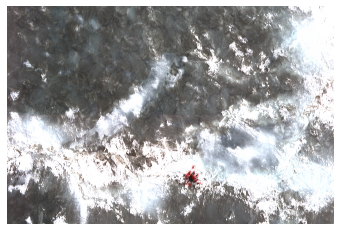

In [ ]:
#load the data
col_names = ["filename", "xmin", "ymin", "xmax", "ymax", "class"]
train_data = pd.read_csv("/content/gdrive/MyDrive/project_6/csv_files/train_data.csv", names=col_names)

#a random image is picked
#file name is printed
#coordinates of all obunding boxes are printed
show_random_image_with_boxes(train_data)

In [ ]:
def show_chosen_image_with_boxes(df, filename):
  #get all rows for this image
  #one bounding box per row
  df2 = df[df["filename"] == filename]
  im = np.array(Image.open(filename))

  #if there is a PNG it will have 4 channels
  #rgb + transparency (alpha channel)
  #our images are all JPG, so no need
  #im = im[:,:, :3]

  boxes = []

  for idx, row in df2.iterrows():
    box = [row["xmin"],
           row["ymin"],
           row["xmax"],
           row["ymax"]]
    boxes.append(box)
  
  for box in boxes:
    print(box)
    
  #use the function from keras_retinanet/utils/visualization.py
  #which is based on cv2 library 
  draw_boxes(im, boxes, color=(255,0,0))

  plt.axis("off")

  #zoom in otherwise the image is too big
  #need to find the xlim, ylim for each images
  #based on the bouding boxes
  plt.xlim(box[0]-100, box[2]+100)
  plt.ylim(box[1]-100, box[3]+100)

  plt.imshow(im)
  # plt.show()

[3611, 3364, 3647, 3438]
[3547, 3377, 3602, 3436]
[3732, 3206, 3784, 3275]
[3784, 3364, 3847, 3434]
[3583, 3459, 3661, 3495]
[3711, 3332, 3749, 3398]
[3744, 3507, 3822, 3541]
[3817, 3544, 3892, 3578]
[3554, 3538, 3613, 3588]
[3654, 3560, 3686, 3630]
[3654, 3315, 3692, 3402]
[3731, 3409, 3772, 3477]
[3772, 3439, 3833, 3496]
[3785, 3481, 3864, 3513]
[3745, 3316, 3774, 3398]


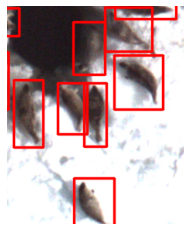

In [ ]:
# filename="polar_bear_2019_fl07_C_20190511_234245.587490_rgb.jpg"
# filename = "test_kotz_2019_fl04_C_20190510_002312.162269_rgb.jpg"
filename = "/content/gdrive/MyDrive/project_6/images/train/test_kotz_2019_fl04_C_20190510_004317.407465_rgb.jpg"
show_chosen_image_with_boxes(train_data, filename)

## Step 3. Check the dimensions of all the images

In [ ]:
image_widths = []  #list to hold image width
image_heights = []  #list to hold image height

#loop over all 1,000 images in the train set
#get the image size and append the the lists above
for filename in data["filename"].unique():
  filepath = "/content/gdrive/MyDrive/project_6/images/train/" + filename
  im = Image.open(filepath)
  width, height = im.size
  image_widths.append(width)
  image_heights.append(height)

In [ ]:
set(image_widths), set(image_heights)
#all images have the same size

({6576}, {4384})

## Step 4. Statistics of the bounding box sizes

In [ ]:
#box width
data["width"] = data["xmax"]-data["xmin"]
#box height
data["height"] = data["ymax"]-data["ymin"]
#box area
data["area"] = data["width"]*data["height"]

data.head()

,filename,xmin,ymin,xmax,ymax,class,width,height,area
0,test_kotz_2019_fl04_C_20190510_000311.417294_r...,3114,3484,3176,3534,ringed_seal,62,50,3100
1,test_kotz_2019_fl04_C_20190510_000529.416720_r...,3136,3682,3210,3746,ringed_seal,74,64,4736
2,test_kotz_2019_fl04_C_20190510_000529.416720_r...,3276,3695,3345,3756,ringed_seal,69,61,4209
3,test_kotz_2019_fl04_C_20190510_001905.413279_r...,6288,60,6316,105,ringed_seal,28,45,1260
4,test_kotz_2019_fl04_C_20190510_001910.663404_r...,3513,193,3551,247,ringed_pup,38,54,2052


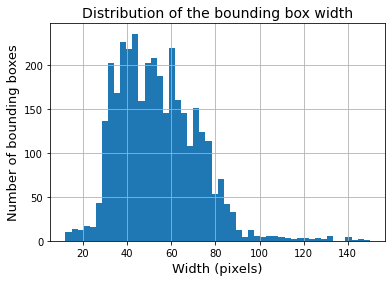

In [ ]:
data["width"].hist(bins=50)
plt.title("Distribution of the bounding box width", fontsize=14)
plt.xlabel("Width (pixels)", fontsize=13)
plt.ylabel("Number of bounding boxes", fontsize=13);
#mostly 50+/-20

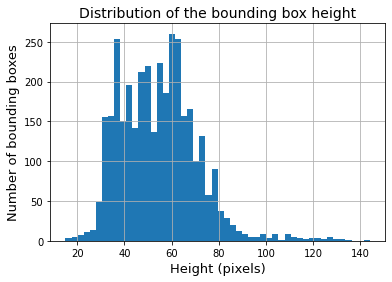

In [ ]:
data["height"].hist(bins=50)
plt.title("Distribution of the bounding box height", fontsize=14)
plt.xlabel("Height (pixels)", fontsize=13)
plt.ylabel("Number of bounding boxes", fontsize=13);
#mostly 50+/-20

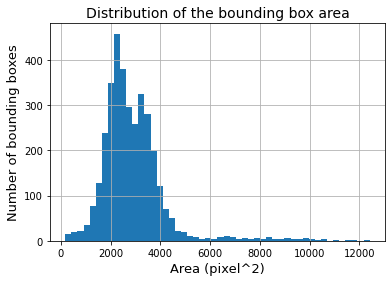

In [ ]:
data["area"].hist(bins=50)
plt.title("Distribution of the bounding box area", fontsize=14)
plt.xlabel("Area (pixel^2)", fontsize=13)
plt.ylabel("Number of bounding boxes", fontsize=13);

In [ ]:
data[["width", "height", "area"]].describe()

,width,height,area
count,3509.000000,3509.000000,3509.000000
mean,53.724423,54.495013,2892.003705
std,17.973616,16.278323,1332.757494
min,12.000000,15.000000,180.000000
25%,40.000000,41.000000,2135.000000
50%,52.000000,54.000000,2652.000000
75%,65.000000,64.000000,3384.000000
max,150.000000,144.000000,12412.000000


Compared to the images, the bounding boxes are about 10,000 times smaller in area (or about 100 times in each dimension).

## Step 5. The dispersion of bounding boxes on each image

We will want to visualize some images with the bounding boxes. Because the images are very large compared to the bounding boxes, the boxes are almost invisible when the images are displayed at full. If the bounding boxes on each image are close to each other, we can zoom in and visualize all the bounding boxes at once, otherwise we will need to visualize a group of bounding boxes at a time.

In [ ]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3509 entries, 0 to 3508
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  3509 non-null   object
 1   xmin      3509 non-null   int64 
 2   ymin      3509 non-null   int64 
 3   xmax      3509 non-null   int64 
 4   ymax      3509 non-null   int64 
 5   class     3509 non-null   object
 6   width     3509 non-null   int64 
 7   height    3509 non-null   int64 
 8   area      3509 non-null   int64 
dtypes: int64(7), object(2)
memory usage: 246.9+ KB


,filename,xmin,ymin,xmax,ymax,class,width,height,area
0,test_kotz_2019_fl04_C_20190510_000311.417294_r...,3114,3484,3176,3534,ringed_seal,62,50,3100
1,test_kotz_2019_fl04_C_20190510_000529.416720_r...,3136,3682,3210,3746,ringed_seal,74,64,4736
2,test_kotz_2019_fl04_C_20190510_000529.416720_r...,3276,3695,3345,3756,ringed_seal,69,61,4209
3,test_kotz_2019_fl04_C_20190510_001905.413279_r...,6288,60,6316,105,ringed_seal,28,45,1260
4,test_kotz_2019_fl04_C_20190510_001910.663404_r...,3513,193,3551,247,ringed_pup,38,54,2052


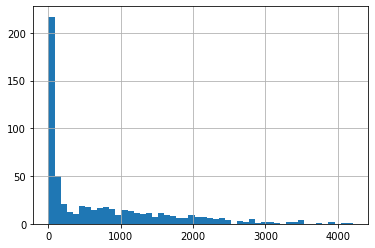

In [ ]:
#For each image, we calculate the standard deviation of the xmin of all the bounding boxes
#We then plot the distribution ot the standard deviation
data.groupby("filename")["xmin"].std().hist(bins=50);

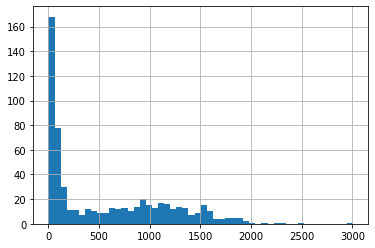

In [ ]:
#Do the same thing for ymin
data.groupby("filename")["ymin"].std().hist(bins=50);

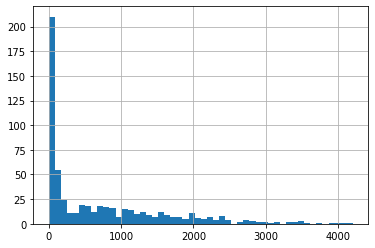

In [ ]:
#Do the same thing for xmax
data.groupby("filename")["xmax"].std().hist(bins=50);

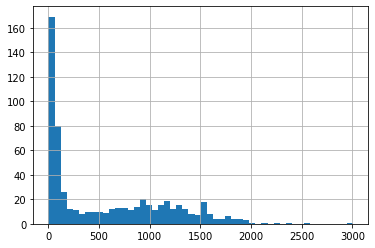

In [ ]:
#Do the same thing for ymax
data.groupby("filename")["ymax"].std().hist(bins=50);

In [ ]:
data.groupby("filename")["xmin"].std().isna().sum()

#the follwing lines also yield 401
# data.groupby("filename")["ymin"].std().isna().sum()
# data.groupby("filename")["xmax"].std().isna().sum()
# data.groupby("filename")["ymax"].std().isna().sum()

401

Out of 1,000 images in the train dataset, 401 have 1 bounding box each. For those with more than 1 bounding boxes, the boxes are pretty spread out. we will need to visualize a group of bounding boxes at a time.

## Step 6. Anchor Optimization

In [ ]:
#clone the following repo https://github.com/martinzlocha/anchor-optimization
#to /content/gdrive/MyDrive/project_6/anchor-optimization

In [ ]:
cd /content/gdrive/MyDrive/project_6/anchor-optimization

'/content/gdrive/MyDrive/project_6/anchor-optimization'

In [ ]:
#install anchor-optimization repo
#to help retinanet work with small bounding boxes
#this repo uses keras_retinanet-0.5.1 by default
#which is an older version
#change it to keras_retinanet-1.0.0 in anchor-optimization/setup.py
!pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/gdrive/MyDrive/project_6/anchor-optimization
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for anchor-optimization: filename=anchor_optimization-0.0.1-cp37-cp37m-linux_x86_64.whl size=82834 sha256=f4fc3ed9e3f51ece816c9f9852d06705a8b69bba2f7ca6fc3ee95b5d4ef56962
  Stored in directory: /root/.cache/pip/wheels/27/b0/9d/8b7bd892823e5b3007f836e2077bc781b168e5203f30fcacca
Successfully built anchor-optimization


In [ ]:
!python setup.py build_ext --inplace

running build_ext
skipping 'anchor_optimization/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.7/anchor_optimization/utils/compute_overlap.cpython-37m-x86_64-linux-gnu.so -> anchor_optimization/utils


In [ ]:
!anchor-optimization "/content/gdrive/MyDrive/project_6/csv_files/train_data.csv" --ratios=5 --no-resize

Optimization ended successfully!

Final best anchor configuration
State: 0.11634
Ratios: [0.502, 0.703, 1.0, 1.422, 1.991]
Scales: [0.469, 0.764, 1.258]
Number of labels that don't have any matching anchor: 0


In [ ]:
#use the ratios and scales
#save them to the config.ini file in /content/gdrive/MyDrive/project_6/keras-retinanet/keras_retinanet/config/
#pass this file to train.py using parameter --config